In [29]:
import os
import json
import cv2
from PIL import Image
from collections import Counter
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from IPython.display import display, HTML
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None) 

Data Loading

In [2]:
def getTrainingLabelData(label_dir):
    for filename in os.listdir(label_dir):
        if filename.endswith('train.json'):
            print(filename)
            with open(os.path.join(label_dir, filename)) as f:
                data = json.load(f)
    return data

def getValidationLabelData(label_dir):
    for filename in os.listdir(label_dir):
        if filename.endswith('val.json'):
            print(filename)
            with open(os.path.join(label_dir, filename)) as f:
                data = json.load(f)
    return data

In [3]:
train_labels = getTrainingLabelData('../data/bdd100k_labels_release/bdd100k/labels') # contains list of json w.r.t. each image for train data

bdd100k_labels_images_train.json


In [4]:
len(train_labels), train_labels[0].keys()

(69863, dict_keys(['name', 'attributes', 'timestamp', 'labels']))

In [5]:
val_labesl = getValidationLabelData('../data/bdd100k_labels_release/bdd100k/labels') # contains list of json w.r.t. each image for val data

bdd100k_labels_images_val.json


In [6]:
len(val_labesl), val_labesl[0].keys()

(10000, dict_keys(['name', 'attributes', 'timestamp', 'labels']))

Analysis

In [7]:
def check_image_sizes(image_dir, sample_size=10):
    sizes = set()
    for idx, filename in enumerate(os.listdir(image_dir)):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(image_dir, filename))
            sizes.add(img.shape[:2])  # (height, width)
            if idx >= sample_size:
                break
    return sizes

def category_to_label_analysis(dataset):
    category_to_label_keys = {}
    for img_data in dataset:
        for label in img_data['labels']:
            category_to_label_keys[label['category']] = label.keys()
    df = pd.DataFrame(list(category_to_label_keys.items()), columns=['label_category', 'label_keys'])
    return df

def getCategoriesCounts(dataset):
    category_counts = Counter()
    for img_data in dataset:
        for label in img_data['labels']:
            category_counts[label['category']] +=1
    df = pd.DataFrame(category_counts.items(), columns=['category', 'count'])
    return df

def getAttributesInfo(dataset):
    attribute = defaultdict(lambda: defaultdict(int))
    for img_data in dataset:
        for key,value in img_data['attributes'].items():
            attribute[key][value] += 1
    rows = []
    for attr_type, values in attribute.items():
        for label, count in values.items():
            rows.append({"attribute_type": attr_type, "label": label, "count": count})

    df = pd.DataFrame(rows)
    return df

def occlusion_truncation_analysis(dataset):
    occlusion_truncation_analysis = defaultdict(lambda: defaultdict(int))
    for img_data in dataset:
        for label in img_data['labels']:
            category = label['category']
            if label['attributes'].get('occluded', False):
                occlusion_truncation_analysis[category]['occluded'] += 1
            if label['attributes'].get('truncated', False):
                occlusion_truncation_analysis[category]['truncated'] += 1
    rows = []
    for category, stats in occlusion_truncation_analysis.items():
        for attr, count in stats.items():
            rows.append({"category": category, "attribute": attr, "count": count})
    df = pd.DataFrame(rows)
    return df

def extract_bbox_stats(dataset):
    classes = ['traffic light', 'traffic sign', 'car', 'person', 'bus', 'truck', 'rider', 'bike', 'motor', 'train']
    areas = []
    aspect_ratios = []
    categories = []
    for item in tqdm(dataset, desc="Processing samples"):
        for label in item.get("labels", []):
            if label["category"] in classes and "box2d" in label:
                box = label["box2d"]
                width = box["x2"] - box["x1"]
                height = box["y2"] - box["y1"]

                if width <= 0 or height <= 0:
                    continue

                area = width * height
                aspect_ratio = width / height

                areas.append(area)
                aspect_ratios.append(aspect_ratio)
                categories.append(label["category"])
    df = pd.DataFrame({
        "category": categories,
        "area": areas,
        "aspect_ratio": aspect_ratios
    })
    return df

def analyze_bbox_positions_by_category(dataset, image_height=720, image_width=1280):
    rows = []

    for image in dataset:
        for label in image['labels']:
            if 'box2d' not in label:
                continue

            category = label['category']
            box = label['box2d']
            x_center = (box['x1'] + box['x2']) / 2
            y_center = (box['y1'] + box['y2']) / 2

            # Determine zones
            if y_center < image_height / 3:
                y_zone = 'top'
            elif y_center < 2 * image_height / 3:
                y_zone = 'middle'
            else:
                y_zone = 'bottom'

            if x_center < image_width / 3:
                x_zone = 'left'
            elif x_center < 2 * image_width / 3:
                x_zone = 'center'
            else:
                x_zone = 'right'

            rows.append({
                'category': category,
                'x_zone': x_zone,
                'y_zone': y_zone
            })

    df = pd.DataFrame(rows)
    return df

def get_object_cooccurrence_df(json_data_list):
    classes = ['traffic light', 'traffic sign', 'car', 'person', 'bus', 'truck', 'rider', 'bike', 'motor', 'train']
    co_occurrence = defaultdict(lambda: defaultdict(int))
    for data in json_data_list:
        labels = data.get("labels", [])
        present_classes = set(
            label["category"] for label in labels if label["category"] in classes
        )
        for cat1 in present_classes:
            for cat2 in present_classes:
                co_occurrence[cat1][cat2] += 1
    # Convert to DataFrame
    df = pd.DataFrame(co_occurrence).fillna(0).astype(int)
    # Reindex rows and columns to ensure consistency
    df = df.reindex(index=classes, columns=classes, fill_value=0)
    return df

def object_density_analysis(data):
    relevant_categories = ['traffic light', 'traffic sign', 'car', 'person', 'bus', 'truck', 'rider', 'bike', 'motor', 'train']
    rows = []
    for item in data:
        image_name = item.get("name", "")
        labels = item.get("labels", [])
        attributes = item.get("attributes", {})
        weather = attributes.get("weather", "unknown")
        scene = attributes.get("scene", "unknown")
        timeofday = attributes.get("timeofday", "unknown")

        count = 0
        for label in labels:
            if "box2d" in label:
                if relevant_categories is None or label["category"] in relevant_categories:
                    count += 1
        rows.append({
            "image_name": image_name,
            "object_count": count,
            "weather": weather,
            "scene": scene,
            "timeofday": timeofday,
        })
    df = pd.DataFrame(rows)
    return df

def find_rare_samples_df(dataset, rare_class_count=5, rare_ratio_threshold=0.6):
    class_dist_df = getCategoriesCounts(dataset) # category counts
    class_counts = dict(zip(class_dist_df["category"], class_dist_df["count"]))
    # Get N rarest classes
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_dict = dict(sorted_counts)
    rare_classes = [cls for cls, _ in sorted_counts[-5:]]
    # Collect rare sample stats
    rare_sample_data = []
    for item in dataset:
        labels = item.get("labels", [])
        total_objects = len(labels)
        if total_objects == 0:
            continue
        rare_objects = sum(1 for obj in labels if obj.get("category") in rare_classes)
        rare_ratio = rare_objects / total_objects
        if rare_ratio >= rare_ratio_threshold:
            rare_sample_data.append({
                "image": item["name"],
                "rare_ratio": round(rare_ratio, 2),
                "rare_objects": rare_objects,
                "total_objects": total_objects,
                "rare_classes_in_image": list({obj["category"] for obj in labels if obj["category"] in rare_classes})
            })
    df = pd.DataFrame(rare_sample_data)
    return df

In [8]:
check_image_sizes('../data/bdd100k_images_100k/bdd100k/images/100k/train', sample_size=100) # for train data

{(720, 1280)}

In [9]:
check_image_sizes('../data/bdd100k_images_100k/bdd100k/images/100k/val', sample_size=100) # for val data

{(720, 1280)}

In [10]:
def plot_category_count(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    # plot
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("viridis", len(df))
    bars = plt.bar(df["category"], df["count"], color=colors)
    plt.xticks(rotation=45)
    plt.title("Object Category Counts in Dataset")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(output_dir, "category_distribution.png"), bbox_inches="tight")
    plt.close()

df = getCategoriesCounts(train_labels) # category counts
plot_category_count(df)
df

,category,count
0,traffic light,186117
1,traffic sign,239686
2,car,713211
3,drivable area,125723
4,lane,528643
5,person,91349
6,bus,11672
7,truck,29971
8,rider,4517
9,bike,7210


In [11]:
# category to label keys
df = category_to_label_analysis(train_labels)
df

,label_category,label_keys
0,traffic light,"(category, attributes, manualShape, manualAttributes, box2d, id)"
1,traffic sign,"(category, attributes, manualShape, manualAttributes, box2d, id)"
2,car,"(category, attributes, manualShape, manualAttributes, box2d, id)"
3,drivable area,"(category, attributes, manualShape, manualAttributes, poly2d, id)"
4,lane,"(category, attributes, manualShape, manualAttributes, poly2d, id)"
5,person,"(category, attributes, manualShape, manualAttributes, box2d, id)"
6,bus,"(category, attributes, manualShape, manualAttributes, box2d, id)"
7,truck,"(category, attributes, manualShape, manualAttributes, box2d, id)"
8,rider,"(category, attributes, manualShape, manualAttributes, box2d, id)"
9,bike,"(category, attributes, manualShape, manualAttributes, box2d, id)"


Note - this shows only drivable area and lane have poly2d else have box2d coordinates, which makes sense as well.

In [ ]:
def plot_attribute_distribution(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    
    for attr in df['attribute_type'].unique():
        subset = df[df['attribute_type'] == attr]

        if subset.empty:
            print(f"[WARN] No data for attribute type: {attr}")
            continue

        plt.figure(figsize=(10, 5))
        sns.barplot(data=subset, x="label", y="count", hue="label", palette="muted", legend=False)
        plt.title(f"{attr.capitalize()} Distribution")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        file_path = os.path.join(output_dir, f"{attr}_distribution.png")
        plt.savefig(file_path)
        plt.close()

df = getAttributesInfo(train_labels) # train data
df_val = getAttributesInfo(val_labesl) # val data
plot_attribute_distribution(df)
display(df, df_val)

,attribute_type,label,count
0,weather,clear,37344
1,weather,rainy,5070
2,weather,undefined,8119
3,weather,snowy,5549
4,weather,overcast,8770
5,weather,partly cloudy,4881
6,weather,foggy,130
7,scene,city street,43516
8,scene,highway,17379
9,scene,residential,8074


,attribute_type,label,count
0,weather,overcast,1239
1,weather,clear,5346
2,weather,undefined,1157
3,weather,rainy,738
4,weather,snowy,769
5,weather,partly cloudy,738
6,weather,foggy,13
7,scene,city street,6112
8,scene,highway,2499
9,scene,tunnel,27


In [20]:
def plot_occlusion_truncation(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    df["total"] = df.groupby("category")["count"].transform("sum")
    df = df.sort_values("total", ascending=False).drop("total", axis=1)

    # Plot grouped bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="category", y="count", hue="attribute")
    plt.xticks(rotation=45)
    plt.title("Occlusion and Truncation Counts per Category")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend(title="Attribute")
    plt.savefig(os.path.join(output_dir, "occlusion_truncation_analysis.png"), bbox_inches="tight")
    plt.close()

df = occlusion_truncation_analysis(train_labels)
plot_occlusion_truncation(df)
df

,category,attribute,count,total
0,traffic sign,truncated,6699,33673
1,traffic sign,occluded,26974,33673
2,person,occluded,52996,56179
3,person,truncated,3183,56179
4,car,occluded,483121,549650
5,car,truncated,66529,549650
6,bus,occluded,7645,9791
7,bus,truncated,2146,9791
8,truck,occluded,19634,24192
9,truck,truncated,4558,24192


In [14]:
def plot_bbox_stats(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)

    # Area distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["area"], bins=100, log_scale=True)
    plt.title("Bounding Box Area Distribution (log scale)")
    plt.xlabel("Area (px^2)")
    plt.ylabel("Count")
    plt.savefig(os.path.join(output_dir, "bbox_area_distribution.png"))
    plt.close()

    # Aspect ratio distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["aspect_ratio"], bins=50)
    plt.title("Bounding Box Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (width / height)")
    plt.ylabel("Count")
    plt.savefig(os.path.join(output_dir, "bbox_aspect_ratio_distribution.png"))
    plt.close()

    # Scatter plot per category
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x="aspect_ratio", y="area", hue="category", alpha=0.5)
    plt.yscale("log")
    plt.title("Aspect Ratio vs Area by Category")
    plt.xlabel("Aspect Ratio")
    plt.ylabel("Area (log scale)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "aspect_ratio_vs_area_by_category.png"))
    plt.close()

df = extract_bbox_stats(train_labels)
plot_bbox_stats(df)
df.head()

Processing samples: 100%|██████████| 69863/69863 [00:01<00:00, 54307.11it/s]


,category,area,aspect_ratio
0,traffic light,2414.353780,0.400000
1,traffic light,2563.388185,0.465116
2,traffic sign,1549.955554,3.076923
3,traffic sign,12304.688432,0.818913
4,car,72945.103027,1.339320


In [15]:
def plot_y_zone_distribution(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    
    # plot vertical position distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='category', hue='y_zone')
    plt.title('Vertical Position Distribution (Top/Middle/Bottom) by Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "vertical_zone_distribution.png"))
    plt.close()

def plot_x_zone_distribution(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)

    # plot horizontal position distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='category', hue='x_zone')
    plt.title('Horizontal Position Distribution (Left/Center/Right) by Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "horizontal_zone_distribution.png"))
    plt.close()

df = analyze_bbox_positions_by_category(train_labels)
plot_y_zone_distribution(df)
plot_x_zone_distribution(df)
df.head()

,category,x_zone,y_zone
0,traffic light,right,top
1,traffic light,right,top
2,traffic sign,right,top
3,traffic sign,left,top
4,car,left,middle


In [16]:
def plot_object_cooccurrence(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df / df.values.max(), annot=True, cmap="Blues")
    plt.title("Object Co-occurrence Heatmap (Normalized)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "object_cooccurrence.png"))
    plt.close()


df = get_object_cooccurrence_df(train_labels)
plot_object_cooccurrence(df)
df

,traffic light,traffic sign,car,person,bus,truck,rider,bike,motor,train
traffic light,39237,34583,38835,16437,5889,10930,2699,3373,1450,60
traffic sign,34583,57154,56453,19190,7587,15592,3145,3847,1920,89
car,38835,56453,69072,21844,8920,18762,3543,4292,2260,104
person,16437,19190,21844,22076,4198,7534,2337,3197,1242,43
bus,5889,7587,8920,4198,8993,3157,715,864,409,14
truck,10930,15592,18762,7534,3157,18890,1180,1502,576,31
rider,2699,3145,3543,2337,715,1180,3586,2422,1274,5
bike,3373,3847,4292,3197,864,1502,2422,4343,393,7
motor,1450,1920,2260,1242,409,576,1274,393,2284,5
train,60,89,104,43,14,31,5,7,5,105


In [17]:
def plot_density_histogram(df, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(10, 6))
    sns.histplot(df["object_count"], bins=range(0, df["object_count"].max()+2, 1), kde=False, color="teal")
    plt.title("Object Density per Image")
    plt.xlabel("Number of Objects")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"object_density_histogram.png"))
    plt.close()

def plot_density_by_attribute(df, attribute, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(8, 5))
    grouped_df = (
        df.groupby(attribute)["object_count"]
        .mean()
        .reset_index()
        .sort_values("object_count", ascending=False)
    )

    grouped_df["category"] = grouped_df[attribute]  # duplicate for hue
    sns.barplot(
        data=grouped_df,
        x=attribute,
        y="object_count",
        hue="category",
        palette="viridis",
        legend=False
    )
    plt.title(f"Average Object Count by {attribute.capitalize()}")
    plt.ylabel("Avg Object Count")
    plt.xlabel(attribute.capitalize())
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"object_density_by_{attribute}.png"))
    plt.close()

df = object_density_analysis(train_labels)
plot_density_histogram(df)
plot_density_by_attribute(df, "timeofday")
plot_density_by_attribute(df, "weather")
plot_density_by_attribute(df, "scene")
df

,image_name,object_count,weather,scene,timeofday
0,0000f77c-6257be58.jpg,7,clear,city street,daytime
1,0000f77c-62c2a288.jpg,6,clear,highway,dawn/dusk
2,0000f77c-cb820c98.jpg,7,clear,residential,dawn/dusk
3,0001542f-5ce3cf52.jpg,13,clear,city street,night
4,0001542f-7c670be8.jpg,8,clear,highway,night
...,...,...,...,...,...
69858,fe172415-3c36f3d1.jpg,17,overcast,highway,daytime
69859,fe189115-11bedd21.jpg,20,partly cloudy,city street,dawn/dusk
69860,fe189115-352995ee.jpg,16,undefined,city street,daytime
69861,fe189115-354e7981.jpg,28,undefined,city street,daytime


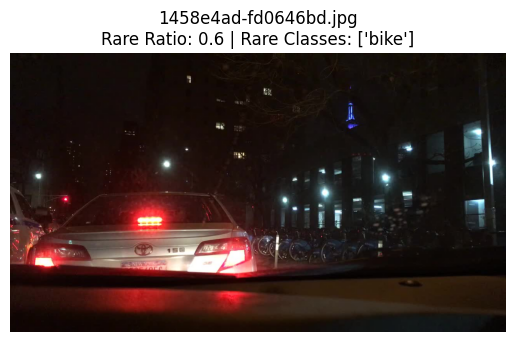

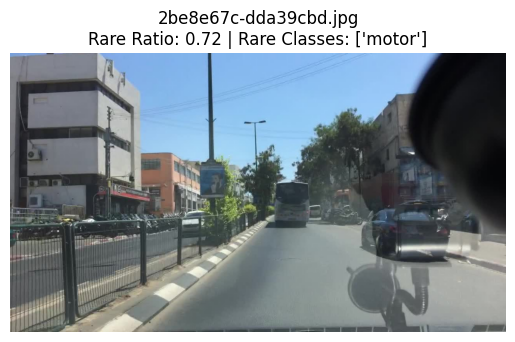

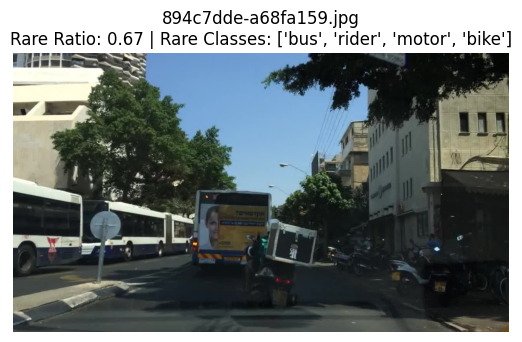

,image,rare_ratio,rare_objects,total_objects,rare_classes_in_image
0,1458e4ad-fd0646bd.jpg,0.60,6,10,[bike]
1,2be8e67c-dda39cbd.jpg,0.72,23,32,[motor]
2,894c7dde-a68fa159.jpg,0.67,12,18,"[bus, rider, motor, bike]"


In [18]:
def show_rare_images(df):
    img_dir = "../data/bdd100k_images_100k/bdd100k/images/100k/train" 
    for _, row in df.head().iterrows():
        img_path = os.path.join(img_dir, row['image'])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{row['image']}\nRare Ratio: {row['rare_ratio']} | Rare Classes: {row['rare_classes_in_image']}")
        plt.show()

rare_samples = find_rare_samples_df(train_labels)
show_rare_images(rare_samples)
rare_samples